In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xbbg import blp
import datetime as dt
import seqm
plt.style.use('dark_background')

In [2]:

# load data
#data_load=blp.bdh(
#                tickers=['BTC1 A:00_0_R Curncy'],
#                flds=['PX_LAST','VOLUME','OPEN_INTEREST'],
#                start_date='1980-01-01',
#                end_date=dt.datetime.now().strftime('%Y-%m-%d'),
#                timeout=100000
#                )
#data_load.columns = data_load.columns.droplevel(0)
#data_load.index=pd.to_datetime(data_load.index)
#data_load.index.name = 'DATE'
#data_load.to_csv('btc1.csv')   




In [3]:
data_future = pd.read_csv('btc1.csv',index_col = 'DATE',parse_dates = True)
data_future = data_future[['PX_LAST']]
data_future

,PX_LAST
DATE,
2017-12-18,28731.25
2017-12-19,27377.42
2017-12-20,25632.49
2017-12-21,23060.21
2017-12-22,21262.63
...,...
2024-05-03,62590.00
2024-05-06,63585.00
2024-05-07,63365.00


In [4]:
data_coin = pd.read_csv('BTC-USD.csv',index_col = 'Date',parse_dates=True)
data_coin = data_coin[['Close']]
data_coin

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2024-05-03,62889.835938
2024-05-04,63891.472656
2024-05-05,64031.132813


In [5]:
data_coin = data_coin[data_coin.index>=data_future.index[0]]

In [6]:
data_coin = data_coin.pct_change()
data_future = data_future.pct_change()
data_coin = data_coin.dropna()
data_future = data_future.dropna()
data_coin.columns = ['coin']
data_future.columns = ['future']

                coin    future
2017-12-19 -0.069974 -0.047120
2017-12-20 -0.064810 -0.063736
2017-12-21 -0.049427 -0.100352
2017-12-22 -0.124730 -0.077952
2017-12-23  0.062711       NaN
...              ...       ...
2024-05-05  0.002186       NaN
2024-05-06 -0.013574  0.015897
2024-05-07 -0.001518 -0.003460
2024-05-08       NaN -0.014282
2024-05-09       NaN -0.017051

[2334 rows x 2 columns]
                coin    future
2017-12-19 -0.069974 -0.047120
2017-12-20 -0.064810 -0.063736
2017-12-21 -0.049427 -0.100352
2017-12-22 -0.124730 -0.077952
2017-12-23  0.062711  0.000000
...              ...       ...
2024-05-05  0.002186  0.000000
2024-05-06 -0.013574  0.015897
2024-05-07 -0.001518 -0.003460
2024-05-08  0.000000 -0.014282
2024-05-09  0.000000 -0.017051

[2334 rows x 2 columns]


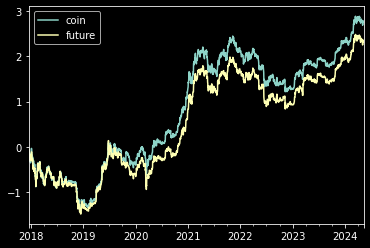

In [7]:
data_both = pd.concat((data_coin,data_future),axis=1)
print(data_both)
data_both = data_both.fillna(0)
print(data_both)
np.cumsum(data_both,axis=0).plot()
plt.show()

In [8]:
px1 = data_coin[['coin']].copy(deep=True)
px1 = px1.dropna()
px1.columns = ['y']
px1['x'] = px1['y'].shift(1)
px1 = px1.dropna()

px2 = data_future[['future']].copy(deep=True)
px2 = px2.dropna()
px2.columns = ['y']
px2['x'] = px2['y'].shift(1)
px2 = px2.dropna()




In [19]:
dataset=seqm.Dataset({'coin':px1,'future':px2})

windows = [e for e in range(5,50)]
windows = [40,80,160]


# model = seqm.GaussianHMM(n_states = 2, n_gibbs = 1000)

model_pipes=seqm.ModelPipes(None)
for key in dataset.keys():
    # model = seqm.MovingAverage(windows = windows, quantile = 0.99, vary_weights = True)
    model = seqm.NIGTrack(phi_m = 0.98, phi_v = 0.92, vi = True, optimize = False)  
    # emissions = [
    #            seqm.GaussianEmission(prior_mean_multiple = -2, posterior_sign = -1), 
    #            seqm.GaussianEmission(prior_mean_multiple = 2, posterior_sign = 1)
    #            ]
    #model = seqm.HMM(emissions = emissions, n_gibbs = 1000)
    #model = seqm.ConditionalGaussianMixture(n_states = 2, n_gibbs = 1000)
    model_pipe_ = seqm.ModelPipe(model = model, w_precision = 0.0001) 
    model_pipes[key] = model_pipe_

paths=dataset.cvbt(
                model_pipes, 
                k_folds=2, 
                seq_path=False, 
                start_fold=0, 
                n_paths=1, 
                burn_fraction=0.1, 
                min_burn_points=3, 
                share_model=True, 
                view_models=False
                )


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


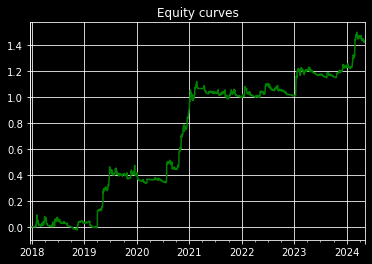

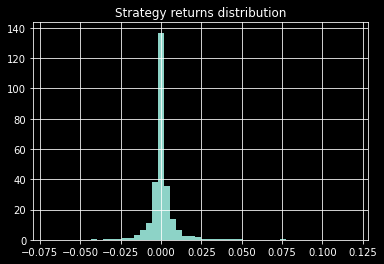

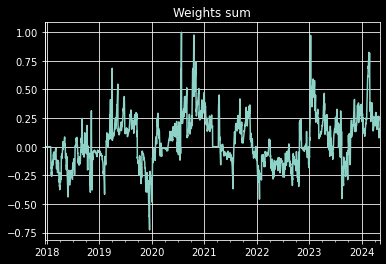

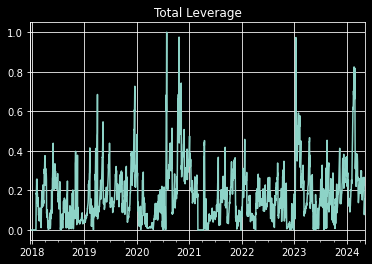


** ACCEPT STRATEGY **


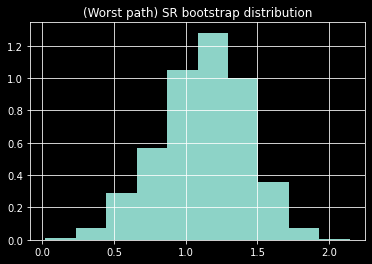


** PERFORMANCE SUMMARY **

Return:  0.15314123607697464
Standard deviation:  0.1355784655203805
Sharpe:  1.1295395289302343



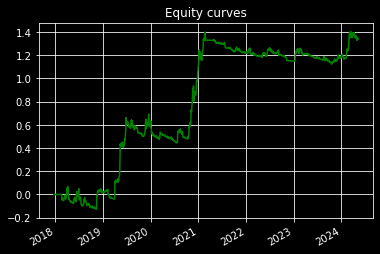

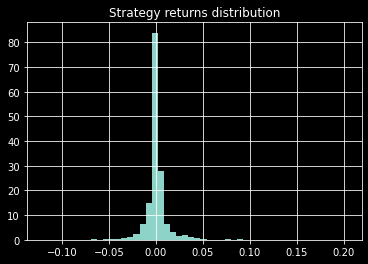

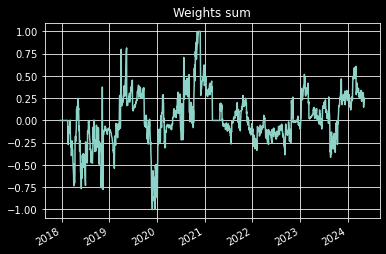

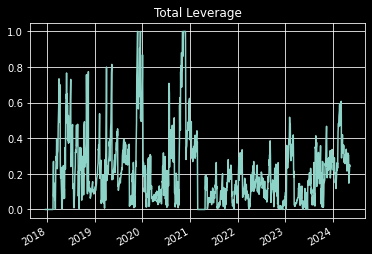


** REJECT STRATEGY **


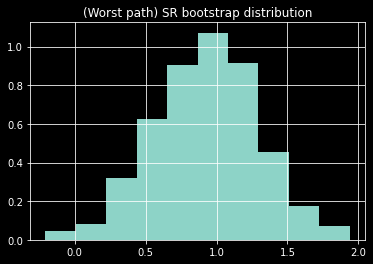


** PERFORMANCE SUMMARY **

Return:  0.2073627329417733
Standard deviation:  0.22372853393551473
Sharpe:  0.9268497374659481



In [20]:
seqm.post_process(paths,pct_fee=0.,seq_fees=False,sr_mult=np.sqrt(250),n_boot=1000,key='coin')
seqm.post_process(paths,pct_fee=0.,seq_fees=False,sr_mult=np.sqrt(250),n_boot=1000,key='future')


In [11]:
w = np.random.normal(0,0.2,3)
w

array([-0.17452957, -0.2044264 ,  0.19552047])

In [12]:
prec = 0.0001

In [13]:
print(np.abs(w)/prec)
print(np.round(np.abs(w)/prec))
new_w = np.sign(w)*np.round(np.abs(w)/prec)*prec
print(new_w)

[1745.29573792 2044.26403322 1955.20473618]
[1745. 2044. 1955.]
[-0.1745 -0.2044  0.1955]


In [14]:
sign_w = np.sign(w)
print(sign)
aux_w = np.abs(w)/prec
print(aux_w)
aux_w = np.array(aux_w,dtype = int)
print(aux_w)
new_w = np.array(aux_w,dtype = float)*prec*sign_w
print(new_w)



NameError: name 'sign' is not defined